# Graph Attention Networks


## Graph Attention Network (GAT) Summary

In Graph Attention Networks, attention mechanisms are applied to determine the influence of neighboring nodes on the target node.

## Graph Convolution Operation with Attention

The output embedding for node $i$ is calculated by aggregating information from its neighbors using attention coefficients $\alpha_{ij}$:

$$
h_i = \sum_{j \in \mathcal{N}_i} \alpha_{ij} W \mathbf{x}_j
$$

where:
- $\mathbf{x}_j$ is the feature vector of the neighboring node $j$,
- $W$ is the shared linear transformation matrix,
- $\alpha_{ij}$ is the attention coefficient between node $i$ and its neighbor $j$.

## Attention Coefficient Calculation

The attention coefficient $\alpha_{ij}$ is computed as:

$$
\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
$$

where $e_{ij}$ is the unnormalized attention score, calculated using a shared attention mechanism:

$$
e_{ij} = \text{LeakyReLU}\left(\mathbf{a}^T [W \mathbf{x}_i || W \mathbf{x}_j]\right)
$$

Here, $\mathbf{a}^T$ is a learnable attention vector, and $\|$ denotes concatenation of the feature vectors.

## Multi-head Attention

To stabilize the learning process and allow the network to capture multiple aspects of the neighborhood, multi-head attention is used. The output of each attention head is computed as:

$$
h_i^k = \sum_{j \in \mathcal{N}_i} \alpha_{ij}^k W^k \mathbf{x}_j
$$

where $k$ represents the index of each attention head. For $K$ attention heads, the final output is computed either by averaging or concatenating the heads:

- Averaging:

$$
h_i = \frac{1}{K} \sum_{k=1}^K h_i^k
$$

- Concatenation:

$$
h_i = \|_{k=1}^K h_i^k
$$

## Final Output of the GAT Layer

The final output of a GAT layer is produced by applying attention to all neighboring nodes and stacking the results from all attention heads. For the entire graph, the output matrix $H$ is given by:

$$
H = \tilde{A}^T W_{\alpha} X W^T
$$

where:
- $\tilde{A}$ is the attention-modified adjacency matrix,
- $W_{\alpha}$ represents the learned attention weights,
- $X$ is the matrix of node features.


## Improved graph attention layer

Brody et al. (2021) argued that the graph attention layer only computes a static type of attention. This is an issue because there are simple graph problems we cannot express with a GAT. So they introduced an improved version, called GATv2, which computes a strictly more expressive dynamic attention.

Their solution consists of modifying the order of operations. The weight matrix $ W $ is applied after the concatenation and the attention weight matrix $ W_{\text{att}} $ after the \textit{LeakyReLU} function.

In summary, here is the original **Graph Attentional Operator**, also GAT:

$$
\alpha_{ij} = \frac{\exp\left(W_{\text{att}} \, \text{LeakyReLU}(W [x_i \, || \, x_j])\right)}{\sum_{k \in \mathcal{N}_i} \exp\left(W_{\text{att}} \, \text{LeakyReLU}(W [x_i \, || \, x_k])\right)}
$$


## We start with an example

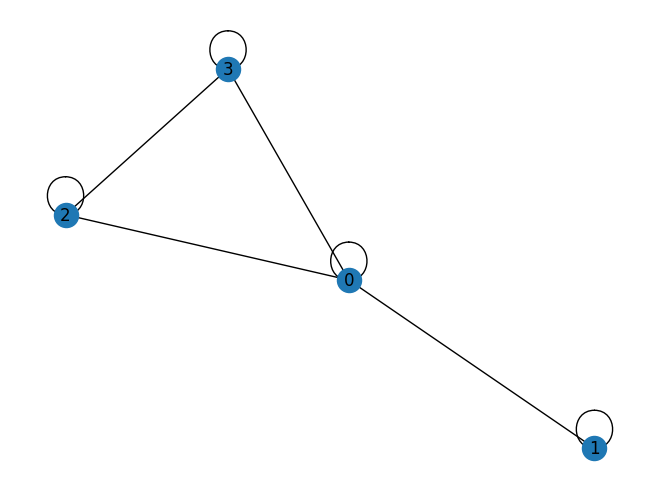

In [68]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
np.random.seed(0)
A = np.array([ # this has a self loop because the diag is 1.
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])
# So we create the graph
G = nx.from_numpy_array(A)

# And then we plot it
nx.draw(G, with_labels=True)
plt.show()

In [69]:
# Generate random matrix for node features:
X = np.random.uniform(-1, 1, (4, 4))
X

array([[ 0.92732552, -0.23311696,  0.58345008,  0.05778984],
       [ 0.13608912,  0.85119328, -0.85792788, -0.8257414 ],
       [-0.95956321,  0.66523969,  0.5563135 ,  0.7400243 ],
       [ 0.95723668,  0.59831713, -0.07704128,  0.56105835]])

In [70]:
# The dimensions of the last W matrix are (num_hid (suppose 2), |V|)
W = np.random.uniform(-1, 1, (2, 4))
W

array([[-0.76345115,  0.27984204, -0.71329343,  0.88933783],
       [ 0.04369664, -0.17067612, -0.47088878,  0.54846738]])

In [71]:
X @ W.T     # This is the vanilla GNN embedding where every node gets a simple embedding with emb_dim = 2

array([[-1.13798007, -0.16273574],
       [ 0.01189352, -0.18823534],
       [ 1.18005851, -0.01155282],
       [-0.0094457 ,  0.28370966]])

This attention matrix is applied to the concatenation of hidden vectors to produce a unique value. Thus, its size needs to be
$ (1, \textit{dim}_h \times 2)$

In [72]:
W_att = np.random.uniform(-1, 1, (1, 4))
W_att

array([[-0.08769934,  0.1368679 , -0.9624204 ,  0.23527099]])

### Attend only the next door neighbours every time.

We want to concatenate hidden vectors from source and destination nodes. A simple way to obtain pairs of source and destination nodes is to look at our adjacency matrix $\tilde{A}$ in COO format: rows store source nodes, and columns store destination nodes. NumPy provides a quick and efficient way of doing it with np.where():

In [73]:
connections = np.where(A > 0) # this is the same as `np.array(G.edges()).T`
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3], dtype=int64),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3], dtype=int64))

In [74]:
# We can concatenate hidden vectors of source and destination nodes using `np.concatenate`
srcs_emb = (X @ W.T)[connections[0]]
tgts_emb = (X @ W.T)[connections[1]]
np.hstack((srcs_emb, tgts_emb))

array([[-1.13798007, -0.16273574, -1.13798007, -0.16273574],
       [-1.13798007, -0.16273574,  0.01189352, -0.18823534],
       [-1.13798007, -0.16273574,  1.18005851, -0.01155282],
       [-1.13798007, -0.16273574, -0.0094457 ,  0.28370966],
       [ 0.01189352, -0.18823534, -1.13798007, -0.16273574],
       [ 0.01189352, -0.18823534,  0.01189352, -0.18823534],
       [ 1.18005851, -0.01155282, -1.13798007, -0.16273574],
       [ 1.18005851, -0.01155282,  1.18005851, -0.01155282],
       [ 1.18005851, -0.01155282, -0.0094457 ,  0.28370966],
       [-0.0094457 ,  0.28370966, -1.13798007, -0.16273574],
       [-0.0094457 ,  0.28370966,  1.18005851, -0.01155282],
       [-0.0094457 ,  0.28370966, -0.0094457 ,  0.28370966]])

In [75]:
# Apply attention to all the 
src_and_tgt_emb_concat = np.hstack([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]])
a = W_att @ src_and_tgt_emb_concat.T 
# so share the attention around the input sequence
#   The input sequence is [src_emb, tgt_emb] and this is how this works
a

array([[ 1.13445504,  0.02179392, -1.06090362,  0.15336619,  1.03012181,
        -0.08253931,  0.95185668, -1.24350198, -0.02923217,  1.09658736,
        -1.0987713 ,  0.11549852]])

In [76]:
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha * x, x)

In [77]:
e = leaky_relu(a)
e

array([[ 1.13445504,  0.02179392, -0.21218072,  0.15336619,  1.03012181,
        -0.01650786,  0.95185668, -0.2487004 , -0.00584643,  1.09658736,
        -0.21975426,  0.11549852]])

In [78]:
E = np.zeros_like(A, dtype=np.float64)
E[connections[0], connections[1]] = e[0]
E

array([[ 1.13445504,  0.02179392, -0.21218072,  0.15336619],
       [ 1.03012181, -0.01650786,  0.        ,  0.        ],
       [ 0.95185668,  0.        , -0.2487004 , -0.00584643],
       [ 1.09658736,  0.        , -0.21975426,  0.11549852]])

### Subtracting max from softmax:
**Numerical stability:** The reason we subtract the maximum value from x before exponentiating is to prevent overflow in the exponential computation. Exponentials can grow very large, especially when dealing with large input values. This could lead to numerical overflow (values becoming too large to be represented), which makes the computation unstable.

In [79]:
def softmax(x, axis):
    e = np.exp(x - np.max(x, axis=axis, keepdims=True))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum
W_alpha = softmax(E ,1)
W_alpha

array([[0.50924284, 0.16737953, 0.13246113, 0.1909165 ],
       [0.48425069, 0.17002969, 0.17285981, 0.17285981],
       [0.48289969, 0.18641069, 0.14536559, 0.18532403],
       [0.50581023, 0.16894517, 0.13561499, 0.1896296 ]])

## Combine all the steps to get the Matrix of Embeddings $H$

In [80]:
H = A.T @ W_alpha @ X @ W.T
H

array([[-1.56257634, -0.25016683],
       [-0.76970241, -0.12550971],
       [-1.21588286, -0.18640132],
       [-1.21588286, -0.18640132]])

# Implementing a GAT in PyTorch Geometric

In [81]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]
data

C:\Users\kosti\anaconda3\envs\llr_env\lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [84]:
import torch 
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from tqdm.auto import tqdm

In [83]:
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

In [93]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout


def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

        self.train()
        for epoch in tqdm(range(epochs+1), desc='Epochs'):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

# Train
gat.fit(data, epochs=100)

# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(3703, 32, heads=8)
  (gat2): GATv2Conv(256, 6, heads=1)
)


Epochs:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch   0 | Train Loss: 28.160 | Train Acc: 11.67% | Val Loss: 1.80 | Val Acc: 17.20%
Epoch  20 | Train Loss: 0.204 | Train Acc: 95.83% | Val Loss: 1.28 | Val Acc: 58.60%
Epoch  40 | Train Loss: 0.153 | Train Acc: 98.33% | Val Loss: 1.33 | Val Acc: 53.80%
Epoch  60 | Train Loss: 0.176 | Train Acc: 95.00% | Val Loss: 1.35 | Val Acc: 55.00%
Epoch  80 | Train Loss: 0.157 | Train Acc: 96.67% | Val Loss: 1.25 | Val Acc: 59.80%
Epoch 100 | Train Loss: 0.163 | Train Acc: 97.50% | Val Loss: 1.32 | Val Acc: 55.80%
GAT test accuracy: 65.10%


In [94]:
# Cora
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]

gat = GAT(dataset.num_features, 32, dataset.num_classes)
gat.fit(data, epochs=100)

acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

C:\Users\kosti\anaconda3\envs\llr_env\lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f)

Epochs:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch   0 | Train Loss: 3.150 | Train Acc: 13.57% | Val Loss: 2.30 | Val Acc: 11.80%
Epoch  20 | Train Loss: 0.228 | Train Acc: 95.71% | Val Loss: 1.13 | Val Acc: 64.40%
Epoch  40 | Train Loss: 0.217 | Train Acc: 97.14% | Val Loss: 1.22 | Val Acc: 63.40%
Epoch  60 | Train Loss: 0.223 | Train Acc: 97.14% | Val Loss: 1.15 | Val Acc: 66.20%
Epoch  80 | Train Loss: 0.228 | Train Acc: 96.43% | Val Loss: 1.15 | Val Acc: 69.60%
Epoch 100 | Train Loss: 0.207 | Train Acc: 96.43% | Val Loss: 1.08 | Val Acc: 67.20%
GAT test accuracy: 79.90%


## CiteSeer Dataset
We will use a new popular dataset for node classification called CiteSeer (MIT License). Like Cora, it represents a network of research papers where each connection is a citation. CiteSeer involves 3327 nodes, whose features represent the presence (1) or absence (0) of 3703 words in a paper. The goal of this dataset is to correctly classify these nodes into six categories. Figure 7.4 shows a plot of CiteSeer made with yEd Live:


In [95]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

<BarContainer object of 32 artists>

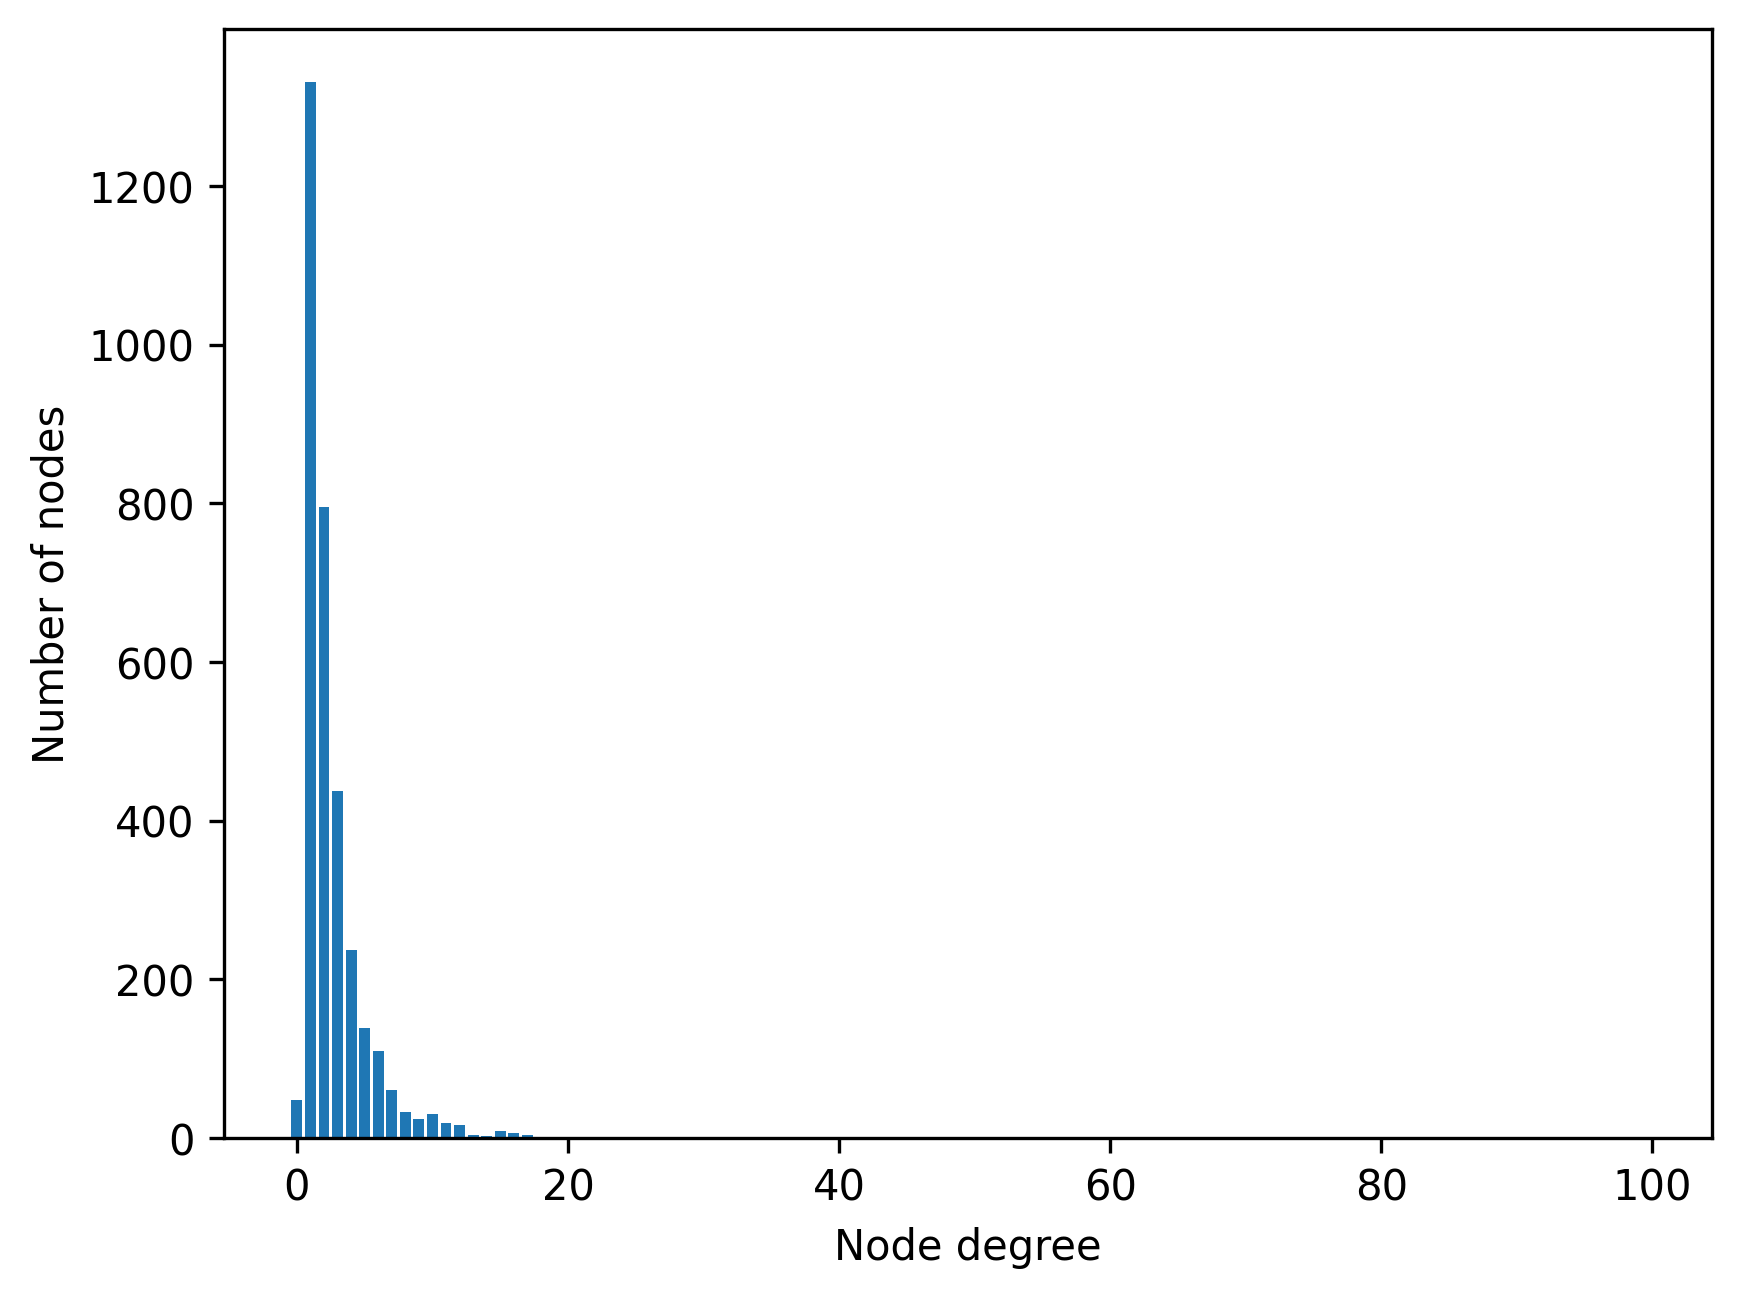

In [96]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter
degrees = degree(dataset[0].edge_index[0]).numpy()
numbers = Counter(degrees)
fig, ax = plt.subplots(dpi=300)
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [97]:
gat = GAT(dataset.num_features, 16, dataset.num_classes)
gat.fit(data, epochs=100)

acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

Epochs:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch   0 | Train Loss: 1.783 | Train Acc: 20.00% | Val Loss: 1.81 | Val Acc: 17.00%
Epoch  20 | Train Loss: 0.191 | Train Acc: 97.50% | Val Loss: 1.19 | Val Acc: 59.00%
Epoch  40 | Train Loss: 0.173 | Train Acc: 98.33% | Val Loss: 1.27 | Val Acc: 55.00%
Epoch  60 | Train Loss: 0.165 | Train Acc: 97.50% | Val Loss: 1.31 | Val Acc: 58.80%
Epoch  80 | Train Loss: 0.222 | Train Acc: 95.00% | Val Loss: 1.42 | Val Acc: 58.20%
Epoch 100 | Train Loss: 0.154 | Train Acc: 97.50% | Val Loss: 1.24 | Val Acc: 61.60%
GAT test accuracy: 67.40%


### poorly connected nodes might negatively impact performance. 
We can verify this hypothesis by plotting the average accuracy score for each node degree:

In [98]:
out = gat(data.x, data.edge_index)
degrees = degree(data.edge_index[0]).numpy()

accuracies = []
sizes = []
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))
    
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

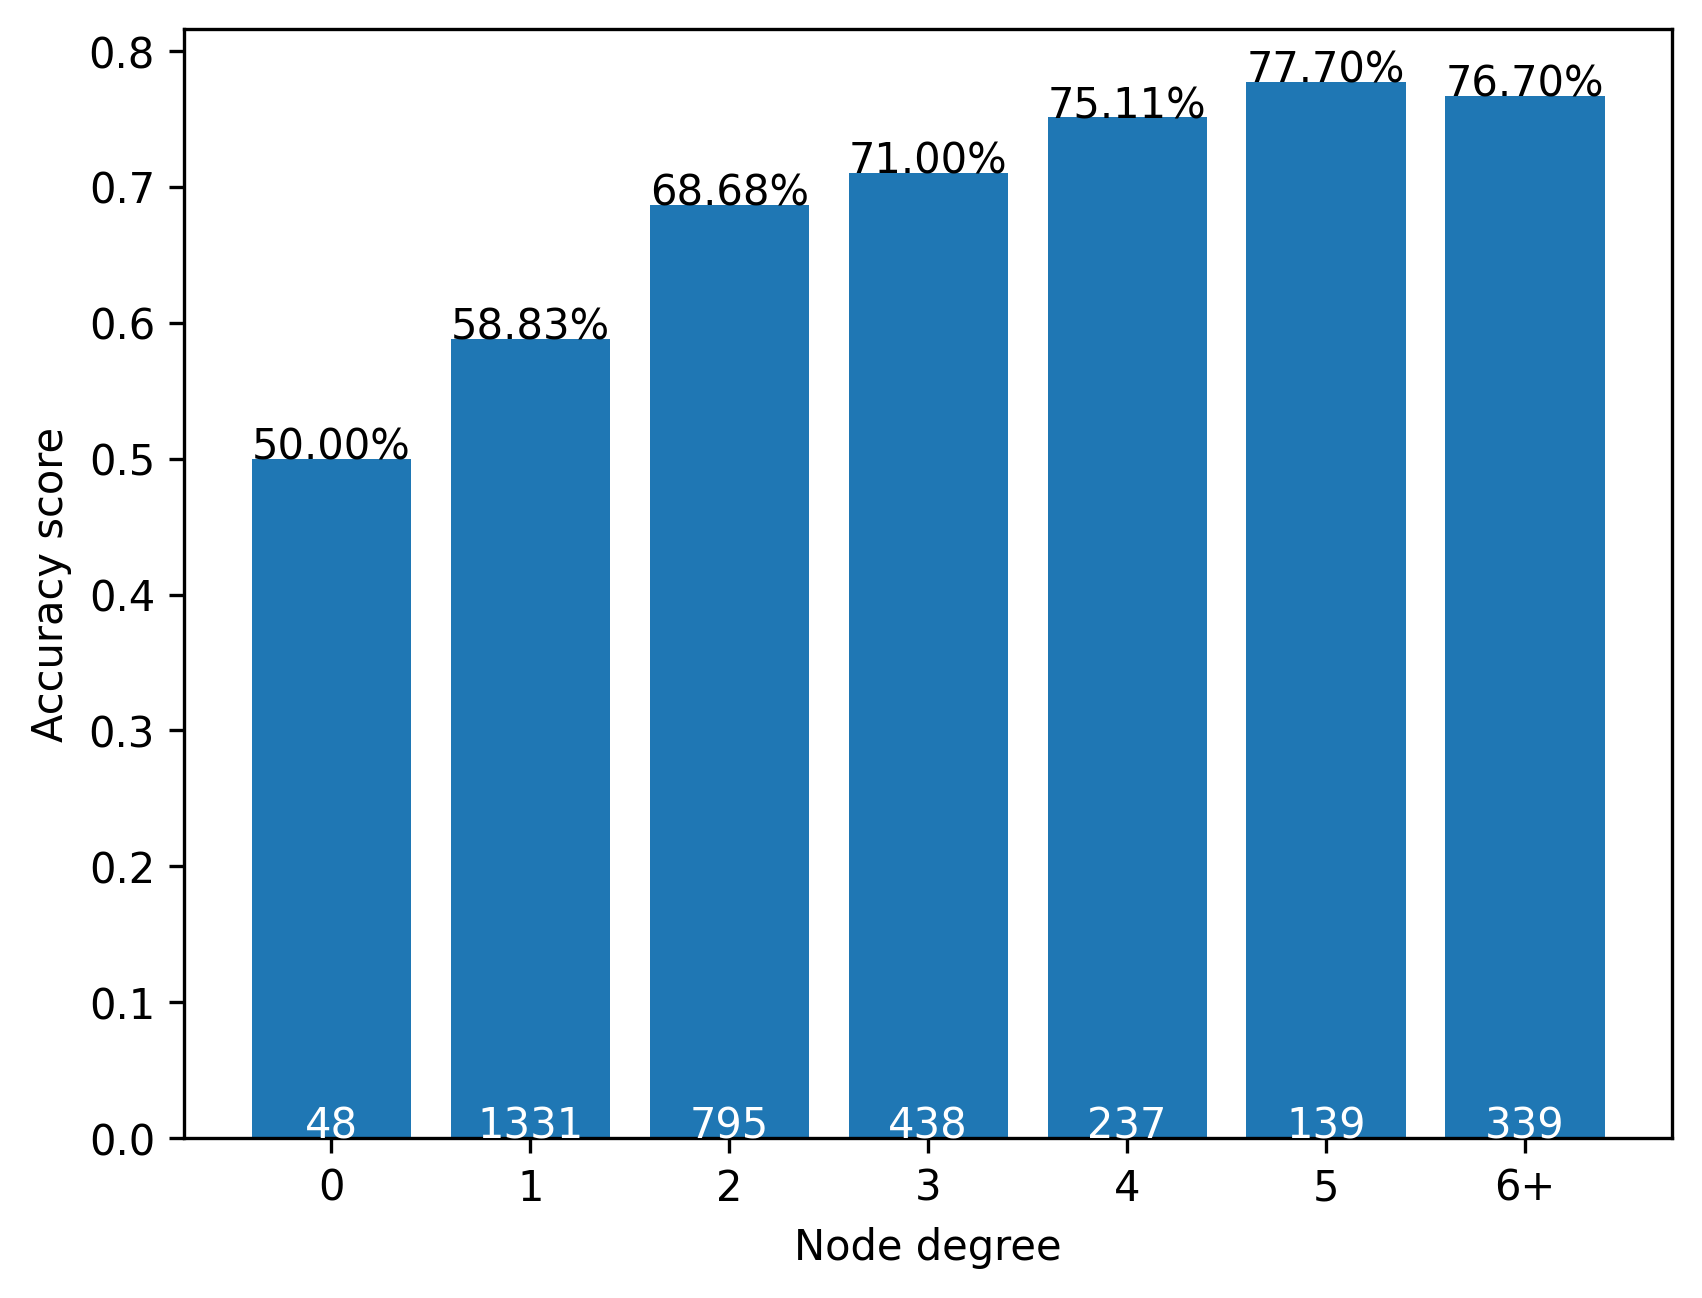

In [99]:
fig, ax = plt.subplots(dpi=300)
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')